<a href="https://colab.research.google.com/github/juliuswiscmsba/NLP-Disaster-Tweets/blob/main/NLP_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NLP Disaster Tweets from Kaggle

BERT to deal with text, and Random Forest work on other columns (combining the result from BERT).

REFERENCE:
1. https://www.kaggle.com/code/tmishinev/nlp-d-tweets-keras-bert-0-83/notebook
2. https://www.kaggle.com/code/datafan07/disaster-tweets-nlp-eda-bert-with-transformers#Building-the-Bert-Model
3. https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
4. https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b
5. https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, Activation, RepeatVector, Bidirectional, LSTM, Dropout, Embedding
from tensorflow.python.keras.layers.embeddings import Embedding 
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier


In [2]:
nltk.download(['stopwords',
               'wordnet',
               'omw-1.4'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
from google.colab import files
train = files.upload()
test = files.upload()

Saving train.csv to train.csv


Saving test.csv to test.csv


In [30]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [31]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [32]:
#Deal with NA
train.keyword.fillna('Unknown', inplace=True)
train.location.fillna('Unknown', inplace=True)
test.keyword.fillna('Unknown', inplace=True)
test.location.fillna('Unknown', inplace=True)

In [33]:
#Observe 'Keywords' column
train.keyword.value_counts().head(20)
#Some unknown value 
#Lemmatize seems to be a good method to deal with it. (weapon and weapons)

Unknown        61
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
evacuate       40
fear           40
outbreak       40
siren          40
twister        40
windstorm      40
collided       40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
Name: keyword, dtype: int64

In [34]:
#Observe 'location' column
train.location.value_counts().head(20)
#Too many unknown value, we should drop this column when running a ML or DL model, otherwise it may create noise that impact our predict.

Unknown            2535
USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Mumbai               22
Washington, DC       21
Kenya                20
Worldwide            19
Chicago, IL          18
Australia            18
California           17
Everywhere           15
California, USA      15
New York, NY         15
Name: location, dtype: int64

Text(0.5, 1.0, 'Distribution of words in each text')

<Figure size 576x360 with 0 Axes>

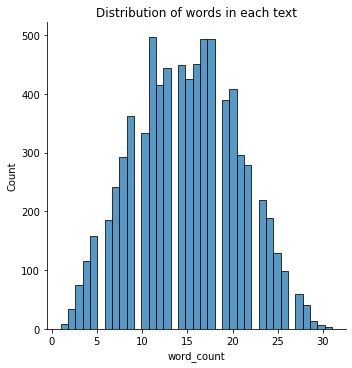

In [35]:
#Observe 'text' column 
train['word_count'] = train['text'].apply(lambda x : len(x.split()))
plt.figure(figsize = (8,5))
sns.displot(data=train, x='word_count')
plt.title("Distribution of words in each text")
#Most tweets contain less than 30 words, and the distribution looks good.

Text(0.5, 1.0, 'Distribution of the Target Label')

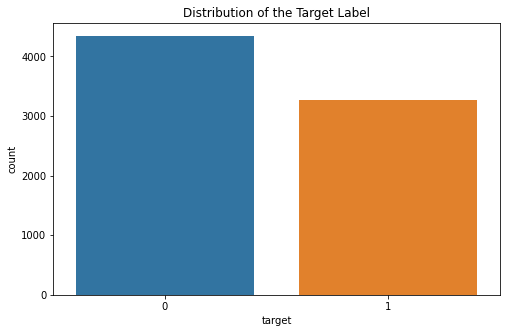

In [36]:
#Oberseve 'target' column
plt.figure(figsize = (8,5))
sns.countplot(data = train, x = 'target')
plt.title('Distribution of the Target Label')
#0 is slightly more than 1 -> if unbalance, we should deal with it.

In [37]:
#Text cleaning and lemmatize
def clean_text(text):
    text = text.lower()
    space = re.compile('[/(){}\[\]\|@,;#]')
    text = re.sub(space,' ', text) 
    ignore = re.compile('[^0-9a-z #+_]')
    text = re.sub(ignore,'', text)
    return text

def remove_stopwords(text):
    StopWords = nltk.corpus.stopwords.words('english')
    text = ' '.join(word for word in text.split() if word not in StopWords) # remove stopwors from text
    return text

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'
        u'\U0001F300-\U0001F5FF'  
        u'\U0001F680-\U0001F6FF'  
        u'\U0001F1E0-\U0001F1FF'  
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def lemmatizer(text):
    text = text.split(" ")
    word_lem = WordNetLemmatizer()
    l_text = ""
    for t in text:
        l = word_lem.lemmatize(t)
        l_text += l
        l_text += " "
    
    return l_text

train['text'] = train['text'].apply(remove_html)
train['text'] = train['text'].apply(remove_emoji)
train['text'] = train['text'].apply(clean_text)
train['text'] = train['text'].apply(remove_stopwords)
train['text'] = train['text'].apply(lemmatizer)
train['keyword'] = train['keyword'].apply(lemmatizer)

test['text'] = test['text'].apply(remove_html)
test['text'] = test['text'].apply(remove_emoji)
test['text'] = test['text'].apply(clean_text)
test['text'] = test['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(lemmatizer)
test['keyword'] = test['keyword'].apply(lemmatizer)

First we build a BiLSTM model using only the text data

In [38]:
X = train.text
y = train.target

In [39]:
#define the LSTM model
def LSTM_model():
    model = tf.keras.Sequential([
        Input(name='inputs',shape=[50]),
        Embedding(len(tok.word_index), 128),
        Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=0.2)),
        Bidirectional(tf.keras.layers.LSTM(64)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])
    
    return model

In [40]:
#Split the train, validation, and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.1, random_state = 42)

In [41]:
#Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

#text to sequences
train_sequences = tok.texts_to_sequences(X_train)
val_sequences = tok.texts_to_sequences(X_val)
test_sequences = tok.texts_to_sequences(X_test)

#pad sequences
X_train_seq = pad_sequences(train_sequences,maxlen=50)
X_val_seq = pad_sequences(val_sequences,maxlen=50)
X_test_seq = pad_sequences(test_sequences,maxlen=50)


lstm_model = LSTM_model()
#train the model
history = lstm_model.fit(X_train_seq, y_train, epochs=15,
                    validation_data =(X_val_seq, y_val), batch_size = 32, 
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False, restore_best_weights=True)])

Epoch 1/15
172/172 [==============================] - 12s 24ms/step - loss: 0.6681 - accuracy: 0.5802 - val_loss: 0.6285 - val_accuracy: 0.6453
Epoch 2/15
172/172 [==============================] - 3s 15ms/step - loss: 0.5302 - accuracy: 0.7395 - val_loss: 0.4880 - val_accuracy: 0.7734
Epoch 3/15
172/172 [==============================] - 3s 18ms/step - loss: 0.3047 - accuracy: 0.8816 - val_loss: 0.5287 - val_accuracy: 0.7816
Epoch 4/15
172/172 [==============================] - 3s 18ms/step - loss: 0.1987 - accuracy: 0.9301 - val_loss: 0.5520 - val_accuracy: 0.7685
Epoch 5/15
172/172 [==============================] - 3s 16ms/step - loss: 0.1299 - accuracy: 0.9564 - val_loss: 0.6523 - val_accuracy: 0.7701
Epoch 6/15
172/172 [==============================] - 3s 15ms/step - loss: 0.0914 - accuracy: 0.9706 - val_loss: 0.6885 - val_accuracy: 0.7570


In [42]:
yhat = np.where(lstm_model.predict(X_test_seq) >=0.5,1,0)

In [43]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       869
           1       0.86      0.64      0.73       654

    accuracy                           0.80      1523
   macro avg       0.82      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523



Accuracy Score:  0.8010505581089954


Text(51.0, 0.5, 'Real')

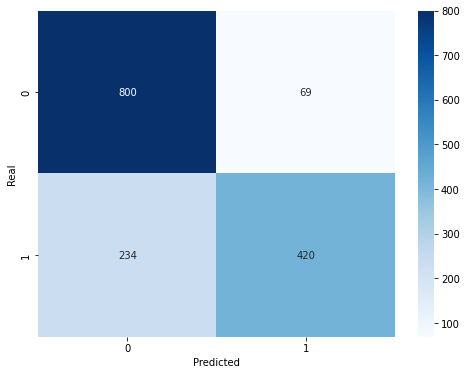

In [44]:
print('Accuracy Score: ', accuracy_score(y_test, yhat))
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test, yhat), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Real')

In [45]:
#StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

X_train_all = train['text']
X_test = test['text']

y_train_list = []
y_test_list = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"Fold: {fold+1},", end=' ')
    X_train, X_val = X[train_idx], X[test_idx]
    y_train, y_val = y[train_idx], y[test_idx]
    
    
    #Tokenizer
    tok = Tokenizer()
    tok.fit_on_texts(X_train)

    #Text to sequences
    train_sequences = tok.texts_to_sequences(X_train)
    val_sequences = tok.texts_to_sequences(X_val)
    test_sequences = tok.texts_to_sequences(X_test)
    train_sequences_all = tok.texts_to_sequences(X_train_all)

    #Padded sequences
    X_train_seq = pad_sequences(train_sequences, maxlen=50)
    X_val_seq = pad_sequences(val_sequences, maxlen=50)
    X_test_seq = pad_sequences(test_sequences, maxlen=50)
    X_train_seq_all = pad_sequences(train_sequences_all, maxlen=50)

    #Modeling
    lstm_model = LSTM_model()
    
    history = lstm_model.fit(X_train_seq, y_train, epochs=15,
                    validation_data =(X_val_seq, y_val), batch_size = 32, 
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', 
                    patience=3, verbose=False, restore_best_weights=True)])


    yhat_val =  np.where(lstm_model.predict(X_val_seq) >=0.5,1,0)
    
    f_score = f1_score(y_val, yhat_val)
    a_score = accuracy_score(y_val, yhat_val)
    print('F1 Score: ', f_score)
    print('Accuracy Score: ', a_score)
    print(classification_report(y_val, yhat_val))
    
    y_train_list.append(lstm_model.predict(X_train_seq_all))
    y_test_list.append(lstm_model.predict(X_test_seq))

print('Done...')

Fold: 1, Epoch 1/15
191/191 [==============================] - 12s 23ms/step - loss: 0.6635 - accuracy: 0.5920 - val_loss: 0.6146 - val_accuracy: 0.6802
Epoch 2/15
191/191 [==============================] - 3s 16ms/step - loss: 0.4828 - accuracy: 0.7814 - val_loss: 0.4334 - val_accuracy: 0.8102
Epoch 3/15
191/191 [==============================] - 3s 16ms/step - loss: 0.2806 - accuracy: 0.8910 - val_loss: 0.4583 - val_accuracy: 0.8070
Epoch 4/15
191/191 [==============================] - 3s 16ms/step - loss: 0.1825 - accuracy: 0.9351 - val_loss: 0.5261 - val_accuracy: 0.8043
Epoch 5/15
191/191 [==============================] - 3s 16ms/step - loss: 0.1190 - accuracy: 0.9578 - val_loss: 0.5904 - val_accuracy: 0.7938
F1 Score:  0.76253081347576
Accuracy Score:  0.8102429415627052
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       868
           1       0.83      0.71      0.76       655

    accuracy                           0.81    

In [46]:
#Store prediction to the submission file
test['target'] = np.where(np.mean(y_test_list, axis = 0) >=0.5, 1,0)
sub_lstm = test[['id','target']].copy()
sub_lstm.to_csv('submission_lstm.csv', index = False)
files.download('submission_lstm.csv')
#Result: 0.79865

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
#Prepare for the random forest model -> we need to probability of the prediction (both train and test)
train['lstm_pred'] = np.mean(y_train_list, axis = 0) 
test['lstm_pred'] = np.mean(y_test_list, axis = 0)

In [48]:
train.head()

,id,keyword,location,text,target,word_count,lstm_pred
0,1,Unknown,Unknown,deed reason earthquake may allah forgive u,1,13,0.792568
1,4,Unknown,Unknown,forest fire near la ronge sask canada,1,7,0.968094
2,5,Unknown,Unknown,resident asked shelter place notified officer ...,1,22,0.967999
3,6,Unknown,Unknown,13 000 people receive wildfire evacuation orde...,1,8,0.975754
4,7,Unknown,Unknown,got sent photo ruby alaska smoke wildfire pour...,1,16,0.762282


BERT

In [13]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.9 MB/s 
     |████████████████████████████████| 6.6 MB 57.9 MB/s 
     |████████████████████████████████| 120 kB 73.8 MB/s 


In [49]:
#Load BERT model
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    hidden_dropout_prob = 0.15,
    attention_probs_dropout_prob = 0.15,
    hidden_act = "relu",
    num_labels = 2
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
#BERT tolenizer
input_ids=[]
attention_masks=[]

sentences=train['text']
labels=train['target']
for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent, add_special_tokens = True, max_length =64, padding='max_length', return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

In [51]:
#Split the train and test data
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids, labels, attention_masks, test_size=0.2)

In [52]:
#BERT model
model_save_path='bert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path, save_weights_only=True, monitor='val_sparse_categorical_accuracy', mode='max', patience=3, save_best_only=True)]

optimizer = tf.keras.optimizers.Adam(
    learning_rate = 1e-5, 
    epsilon = 1e-07,
    clipvalue = 10
)
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=tf.keras.metrics.SparseCategoricalAccuracy())
bert_model.trainable = True
bert_model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [53]:
history=bert_model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=7,validation_data=([val_inp,val_mask],val_label), callbacks=callbacks)

Epoch 1/7
191/191 [==============================] - 93s 408ms/step - loss: 0.5649 - sparse_categorical_accuracy: 0.7103 - val_loss: 0.4378 - val_sparse_categorical_accuracy: 0.8043
Epoch 2/7
191/191 [==============================] - 78s 407ms/step - loss: 0.4175 - sparse_categorical_accuracy: 0.8184 - val_loss: 0.4139 - val_sparse_categorical_accuracy: 0.8168
Epoch 3/7
191/191 [==============================] - 76s 397ms/step - loss: 0.3775 - sparse_categorical_accuracy: 0.8452 - val_loss: 0.4094 - val_sparse_categorical_accuracy: 0.8148
Epoch 4/7
191/191 [==============================] - 77s 406ms/step - loss: 0.3350 - sparse_categorical_accuracy: 0.8655 - val_loss: 0.4068 - val_sparse_categorical_accuracy: 0.8221
Epoch 5/7
191/191 [==============================] - 78s 407ms/step - loss: 0.3093 - sparse_categorical_accuracy: 0.8744 - val_loss: 0.4383 - val_sparse_categorical_accuracy: 0.8247
Epoch 6/7
191/191 [==============================] - 76s 398ms/step - loss: 0.2739 - spars

In [54]:
#Validation prediction
preds = bert_model.predict([val_inp,val_mask],batch_size=32)
pred_labels = np.argmax(preds.logits, axis=1)
f_score = f1_score(val_label,pred_labels)
a_score = accuracy_score(val_label,pred_labels)
print('F1 Score: ', f_score)
print('Accuracy Score: ', a_score)
print('Classification Report:')
print(classification_report(val_label,pred_labels))

print('Training and saving built model.....')   

F1 Score:  0.7919876733436054
Accuracy Score:  0.8227183191070256
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       844
           1       0.83      0.76      0.79       679

    accuracy                           0.82      1523
   macro avg       0.82      0.82      0.82      1523
weighted avg       0.82      0.82      0.82      1523

Training and saving built model.....


In [55]:
#Tokenize test data
input_ids_test=[]
attention_masks_test=[]

sentences=test['text']
for sent in sentences:
    bert_inp_test=bert_tokenizer.encode_plus(sent, add_special_tokens = True,max_length =64, padding='max_length', return_attention_mask = True)
    input_ids_test.append(bert_inp_test['input_ids'])
    attention_masks_test.append(bert_inp_test['attention_mask'])

input_ids_test=np.asarray(input_ids_test)
attention_masks_test=np.array(attention_masks_test)

In [56]:
preds_test = bert_model.predict([input_ids_test,attention_masks_test],batch_size=32)
test['target']  = np.argmax(preds_test.logits, axis=1)
sub_bert = test[['id','target']].copy()
sub_bert.to_csv('submission_bert.csv', index = False)
files.download('submission_bert.csv')
#Result: 0.81612

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
#Prepare for the random forest model -> we need to probability of the prediction (using softmax function)
preds_train = bert_model.predict([input_ids, attention_masks],batch_size=32)
train['bert_pred'] = tf.nn.softmax(preds_train.logits, axis=1)[:,1]
test['bert_pred'] = tf.nn.softmax(preds_test.logits, axis=1)[:,1]

Random Forest

In [58]:
X_rf = train[['keyword', 'lstm_pred', 'bert_pred']]
y_rf = train['target']
test_rf = test[['keyword', 'lstm_pred', 'bert_pred']]

In [59]:
#LabelEncoder for keywords
le = LabelEncoder()
X_rf['keyword'] = le.fit_transform(X_rf['keyword'])
test_rf['keyword'] = le.transform(test_rf['keyword'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [60]:
#Split to train and validation data
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state = 42)

Accuracy Score:  0.9258043335521996


Text(51.0, 0.5, 'Real')

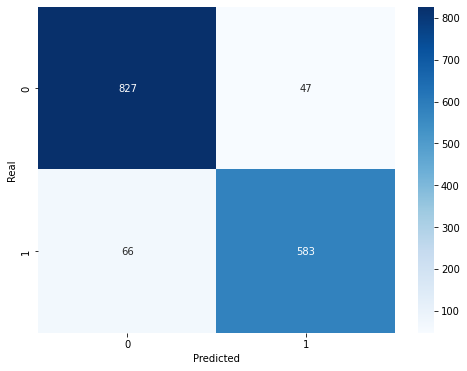

In [61]:
#Random Forest model
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train_rf, y_train_rf)

y_pred_rf = rf.predict(X_val_rf)

print("Accuracy Score: ", accuracy_score(y_val_rf, y_pred_rf))
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_val_rf, y_pred_rf), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Real')

In [62]:
#Store result and submission
target = rf.predict(test_rf)
test['target'] = target
sub_rf = test[['id','target']].copy()
sub_rf.to_csv('submission_rf.csv', index = False)
files.download('submission_rf.csv')
#Result: 0.81642

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

When we combine BERT with Random Forest, it only improve a little (No improvement). 

The reason may be the keywords are already contained in the text, which BERT already deal with it.

Future Improvement:

1. Apply the Large BERT Model
2. Better data cleanning process
3. Fine tuning 
4. Other model (Glove, ALBERT...)